In [8]:
from typing import Dict, Tuple
import h5py
import numpy as np
import os
import cv2
from PIL import Image


def get_path_in_parent(*args):
    return os.path.abspath(os.path.join(os.getcwd(), '..', *args))

def get_path_in_storage(*args):
    return get_path_in_parent("storage", *args)

def get_model_paths(model_num: int):
    path = get_path_in_parent(f"yolo_model_{model_num}")
    return (
        os.path.join(path, f"yolov4-tiny-logistics_size_416_{model_num}.weights"),
        os.path.join(path, f"yolov4-tiny-logistics_size_416_{model_num}.cfg")
    )

def get_outputs(model_num: int) -> Dict[str, Tuple[np.ndarray, ...]]:
    net = cv2.dnn.readNet(*get_model_paths(model_num))

    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    outputs = {}
    logistics_path = get_path_in_storage("logistics")
    for filename in os.listdir(logistics_path):
        if not filename.lower().endswith(".jpg"):
            continue

        image = np.array(Image.open(os.path.join(logistics_path, filename)))

        blob = cv2.dnn.blobFromImage(image,
                                     scalefactor = 1 / 255.,
                                     size=(416, 416),
                                     mean=(0, 0, 0),
                                     swapRB=True,
                                     crop=False)

        net.setInput(blob)

        outputs[filename[:-4]] = net.forward(output_layers)

    return outputs

def save_outputs(model_num: int, outputs: Dict[str, Tuple[np.ndarray, ...]], nms: bool = False) -> None:
    """Save a dict of tuples of arrays to an HDF5 file."""
    path = get_path_in_storage(f"outputs_{model_num}{"_nms" if nms else ""}.h5")
    with h5py.File(path, "w") as f:
        for key, tup in outputs.items():
            grp = f.create_group(str(key))
            for i, arr in enumerate(tup):
                grp.create_dataset(
                    f"array_{i}", data=arr, compression="gzip", compression_opts=1
                )

def load_outputs(model_num: int, nms: bool = False) -> Dict[str, Tuple[np.ndarray, ...]]:
    """Load a dict of tuples of arrays from an HDF5 file."""
    path = get_path_in_storage(f"outputs_{model_num}{"_nms" if nms else ""}.h5")
    outputs_loaded = {}
    with h5py.File(path, "r") as f:
        for key in f.keys():
            grp = f[key]
            arrays = tuple(np.array(grp[subkey]) for subkey in sorted(grp.keys()))
            outputs_loaded[key] = arrays
    return outputs_loaded

def apply_nms(outputs: Dict[str, Tuple[np.ndarray, ...]],
              conf_threshold: float = 0.5,
              nms_threshold: float = 0.4
             ) -> Dict[str, Tuple[np.ndarray, ...]]:
    """
    Apply Non-Max Suppression (NMS) to YOLO-style outputs.

    Args:
        outputs (dict): filename -> raw outputs from get_outputs()
        conf_threshold (float): confidence threshold
        nms_threshold (float): IoU threshold for NMS

    Returns:
        dict: filename -> tuple of np.ndarrays, same format as net.forward
    """
    filtered_outputs = {}

    for fname, layer_outputs in outputs.items():
        detections = []

        for out in layer_outputs:  # out shape: (N, 85)
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = detection[4] * scores[class_id]

                if confidence > conf_threshold:
                    cx, cy, w, h = detection[0:4]
                    x = cx - w / 2
                    y = cy - h / 2

                    # build YOLO-style detection row
                    det_row = np.zeros_like(detection)
                    det_row[0:4] = [x, y, w, h]
                    det_row[4] = detection[4]          # objectness
                    det_row[5:] = 0.0
                    det_row[5 + class_id] = scores[class_id]  # keep only top class

                    detections.append((det_row, confidence))

        if not detections:
            filtered_outputs[fname] = (np.zeros((0, 85), dtype=np.float32),)
            continue

        # unpack for NMS
        boxes = []
        confidences = []
        det_rows = []
        for det_row, conf in detections:
            x, y, w, h = det_row[0:4]
            boxes.append([int(x), int(y), int(w), int(h)])
            confidences.append(float(conf))
            det_rows.append(det_row)

        indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

        if len(indices) > 0:
            final = np.array([det_rows[i] for i in indices.flatten()], dtype=np.float32)
        else:
            final = np.zeros((0, 85), dtype=np.float32)

        # wrap in tuple (to mimic net.forward output structure)
        filtered_outputs[fname] = (final,)

    return filtered_outputs

# First time running model

In [ ]:
outputs_1 = get_outputs(1)
save_outputs(1, outputs_1)

In [6]:
outputs_2 = get_outputs(2)
save_outputs(2, outputs_2)

In [4]:
outputs_1_nms = apply_nms(outputs_1)
save_outputs(1, outputs_1_nms, nms=True)

In [5]:
outputs_2_nms = apply_nms(outputs_2)
save_outputs(2, outputs_1_nms, nms=True)

# After first time

In [2]:
outputs_1 = load_outputs(1)

In [3]:
outputs_2 = load_outputs(2)

In [9]:
outputs_1_nms = load_outputs(1, nms=True)

In [10]:
outputs_2_nms = load_outputs(2, nms=True)

# Calculate Metrics

## Before NMS

In [4]:
def get_ground_truths() -> Dict[str, np.ndarray]:
    logistics_path = get_path_in_storage("logistics")
    res = {}

    for filename in os.listdir(logistics_path):
        if filename.endswith(".txt"):
            filepath = os.path.join(logistics_path, filename)

            with open(filepath, "r") as f:
                lines = []

                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:  # expecting 5 values
                        t = (
                            int(parts[0]),
                            float(parts[1]),
                            float(parts[2]),
                            float(parts[3]),
                            float(parts[4]),
                        )
                        lines.append(t)

                res[filename[:-4]] = np.array(lines)

    return res

In [5]:
from torchvision.ops import box_iou
from torch import Tensor
import torch

def cxcywh_to_xyxy(boxes: Tensor) -> Tensor:
    # boxes: (N, 4) in [cx, cy, w, h]
    xyxy = torch.zeros_like(boxes)
    xyxy[:, 0] = boxes[:, 0] - boxes[:, 2] / 2  # x1
    xyxy[:, 1] = boxes[:, 1] - boxes[:, 3] / 2  # y1
    xyxy[:, 2] = boxes[:, 0] + boxes[:, 2] / 2  # x2
    xyxy[:, 3] = boxes[:, 1] + boxes[:, 3] / 2  # y2
    return xyxy

def get_precision_and_recall(outputs: Dict[str, Tuple[np.ndarray, ...]],
                             ground_truths: Dict[str, np.ndarray],
                             confidence_threshold: float,
                             iou_threshold: float) -> Tuple[float, float]:

    correct_predictions = 0
    total_predictions = 0
    total_ground_truths = sum(len(gt) for _, gt in ground_truths.items())

    for key in outputs:
        output = outputs[key]
        gt = ground_truths[key]

        for feature_maps in output:
            for detection in feature_maps:
                box = detection[:4]
                score = detection[4]
                class_scores = detection[5:]
                class_id = np.argmax(class_scores)

                confidence = score * class_scores[class_id]
                if confidence < confidence_threshold:
                    continue

                total_predictions += 1

                # Extract IDs (shape: N,)
                gt_ids = gt[:, 0]

                # Extract boxes (shape: N, 4)
                gt_boxes = gt[:, 1:5]

                boxes_xyxy = cxcywh_to_xyxy(torch.from_numpy(box).unsqueeze(0))
                gts_xyxy = cxcywh_to_xyxy(torch.tensor(gt_boxes))

                ious = box_iou(boxes_xyxy, gts_xyxy)[0]
                for iou, gt_id in zip(ious, gt_ids):
                    if iou >= iou_threshold and class_id == gt_id:
                        # This is a correct prediction
                        correct_predictions += 1
                        continue

    print(correct_predictions, total_predictions, total_ground_truths)
    return correct_predictions / total_predictions, correct_predictions / total_ground_truths

In [6]:
gts: Dict[str, np.ndarray] = get_ground_truths()

In [7]:
get_precision_and_recall(outputs_1, gts, 0.5, 0.4)

/var/folders/1y/4sm5vl2d7_xdd0jwk0tgnhn00000gn/T/ipykernel_5596/790632341.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  boxes_xyxy = cxcywh_to_xyxy(torch.tensor([box]))


11109 12059 36721


(0.9212206650634381, 0.3025244410555268)

In [8]:
get_precision_and_recall(outputs_2, gts, 0.5, 0.4)

15183 16082 36721


(0.9440989926626041, 0.4134691321042455)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Sweep over confidence thresholds
thresholds = np.linspace(0, 1, 50)
iou_threshold = 0.4

precisions_1, recalls_1 = [], []
precisions_2, recalls_2 = [], []

for t in thresholds:
    p1, r1 = get_precision_and_recall(outputs_1, gts, t, iou_threshold)
    p2, r2 = get_precision_and_recall(outputs_2, gts, t, iou_threshold)

    precisions_1.append(p1)
    recalls_1.append(r1)
    precisions_2.append(p2)
    recalls_2.append(r2)

# Plot PR curves
plt.figure(figsize=(8,6))
plt.plot(recalls_1, precisions_1, label="Model 1", marker="o", markersize=3, linestyle="-")
plt.plot(recalls_2, precisions_2, label="Model 2", marker="s", markersize=3, linestyle="-")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

41536 24145875 36721
47992 24145875 36721
36489 49252 36721
43028 54344 36721
36390 49049 36721
42887 54122 36721
32618 42595 36721
38826 47632 36721
29754 37892 36721
35716 42886 36721
27540 34425 36721
33316 39302 36721
25697 31650 36721
31355 36546 36721
24237 29419 36721
29721 34268 36721
22968 27549 36721
28346 32389 36721
21788 25860 36721
27081 30734 36721
20784 24446 36721
25922 29160 36721
19830 23111 36721
24829 27754 36721
18910 21885 36721
23820 26456 36721
18031 20742 36721
22982 25384 36721
17262 19751 36721
22111 24298 36721
16537 18789 36721
21336 23346 36721
15873 17954 36721
20581 22428 36721
15246 17159 36721
19887 21583 36721
14607 16361 36721
19157 20710 36721
14049 15659 36721
18480 19904 36721
13488 14961 36721
17833 19142 36721
12951 14272 36721
17228 18433 36721
12398 13593 36721
16655 17744 36721
11866 12970 36721
16075 17079 36721
11360 12356 36721
15469 16409 36721
10859 11747 36721
14893 15758 36721
10337 11138 36721
14350 15155 36721
9861 10579 36721
13806

ZeroDivisionError: division by zero

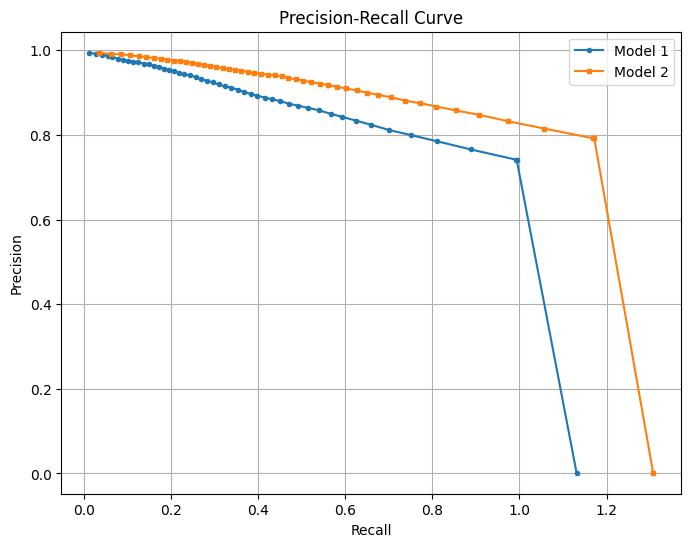

In [11]:
# Plot PR curves
plt.figure(figsize=(8,6))
plt.plot(recalls_1, precisions_1, label="Model 1", marker="o", markersize=3, linestyle="-")
plt.plot(recalls_2, precisions_2, label="Model 2", marker="s", markersize=3, linestyle="-")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)

## After NMS

In [16]:
import multiprocessing as mp
from multiprocessing import Manager
from typing import Dict, Tuple
import numpy as np


def worker(model_name: str,
           outputs: Dict[str, Tuple[np.ndarray, ...]],
           gts: Dict[str, np.ndarray],
           conf_threshold: float,
           iou_threshold: float,
           return_dict):
    """
    Worker function to compute precision/recall for a given model.
    """
    precision, recall = get_precision_and_recall(outputs, gts, conf_threshold, iou_threshold)
    return_dict[model_name] = (precision, recall)


def evaluate_models_with_mp(output_1_nms, output_2_nms, gts,
                            conf_threshold: float = 0.5,
                            iou_threshold: float = 0.4):
    """
    Run per-class precision/recall evaluation in parallel
    using multiprocessing with shared memory.
    """
    with Manager() as manager:
        # Shared dictionary for results
        return_dict = manager.dict()

        # Launch processes
        p1 = mp.Process(target=worker,
                        args=("model_1", output_1_nms, gts, conf_threshold, iou_threshold, return_dict))
        p2 = mp.Process(target=worker,
                        args=("model_2", output_2_nms, gts, conf_threshold, iou_threshold, return_dict))

        p1.start()
        p2.start()
        p1.join()
        p2.join()

        results = dict(return_dict)

    return results


# Example usage:
results = evaluate_models_with_mp(outputs_1_nms, outputs_2_nms, gts, 0.5, 0.4)
print(results)  # {"model_1": (precision, recall), "model_2": (precision, recall)}

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/andrewjowe/opt/anaconda3/envs/TechTrackDesign/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/andrewjowe/opt/anaconda3/envs/TechTrackDesign/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'worker' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>


KeyboardInterrupt: 

In [ ]:
import numpy as np
import multiprocessing as mp
from multiprocessing import shared_memory
from typing import Dict, Tuple


def dict_to_shm(dict_data: Dict[str, np.ndarray]):
    """
    Store dict of numpy arrays in shared memory.
    Returns (shm_dict, shapes, dtypes) for reconstruction.
    """
    shm_dict = {}
    shapes, dtypes = {}, {}
    for k, arr in dict_data.items():
        arr = np.asarray(arr)
        shm = shared_memory.SharedMemory(create=True, size=arr.nbytes)
        shm_arr = np.ndarray(arr.shape, dtype=arr.dtype, buffer=shm.buf)
        shm_arr[:] = arr[:]  # copy data into shared block
        shm_dict[k] = shm.name
        shapes[k] = arr.shape
        dtypes[k] = arr.dtype.str
    return shm_dict, shapes, dtypes


def shm_to_dict(shm_dict, shapes, dtypes):
    """
    Reconstruct dict of numpy arrays from shared memory handles.
    """
    res = {}
    for k, name in shm_dict.items():
        shm = shared_memory.SharedMemory(name=name)
        arr = np.ndarray(shapes[k], dtype=np.dtype(dtypes[k]), buffer=shm.buf)
        res[k] = arr
    return res


def worker(model_name: str,
           shm_outputs, outputs_shapes, outputs_dtypes,
           shm_gts, gts_shapes, gts_dtypes,
           conf_threshold: float,
           iou_threshold: float,
           return_dict):
    """
    Worker: compute per-class precision/recall.
    """
    outputs = shm_to_dict(shm_outputs, outputs_shapes, outputs_dtypes)
    gts = shm_to_dict(shm_gts, gts_shapes, gts_dtypes)

    # 🔑 Call your existing function that computes *per-class* precision & recall
    per_class_results = get_precision_and_recall(outputs, gts, conf_threshold, iou_threshold)

    return_dict[model_name] = per_class_results


def evaluate_models_with_mp(output_1_nms, output_2_nms, gts,
                            conf_threshold: float = 0.5,
                            iou_threshold: float = 0.4):
    """
    Parallel per-class precision/recall evaluation with true shared memory.
    """
    # Store in shared memory
    shm_out1, out1_shapes, out1_dtypes = dict_to_shm(output_1_nms)
    shm_out2, out2_shapes, out2_dtypes = dict_to_shm(output_2_nms)
    shm_gts, gts_shapes, gts_dtypes = dict_to_shm(gts)

    with mp.Manager() as manager:
        return_dict = manager.dict()

        p1 = mp.Process(target=worker,
                        args=("model_1", shm_out1, out1_shapes, out1_dtypes,
                              shm_gts, gts_shapes, gts_dtypes,
                              conf_threshold, iou_threshold, return_dict))
        p2 = mp.Process(target=worker,
                        args=("model_2", shm_out2, out2_shapes, out2_dtypes,
                              shm_gts, gts_shapes, gts_dtypes,
                              conf_threshold, iou_threshold, return_dict))

        p1.start()
        p2.start()
        p1.join()
        p2.join()

        results = dict(return_dict)

    return results
